# 3. Exercise: Livio Garofalo 11808000 {-}

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import xarray as xr
import pymannkendall as mk
import scipy.signal
import scipy.stats
from dask.diagnostics import progress
from collections import defaultdict
from sklearn.decomposition import PCA
import dask
import intake
import cartopy.crs as ccrs
import random
import warnings
import copy
import os
warnings.filterwarnings("ignore")

# 1) First steps on GitHub {-}
Open a GitHub account (if you don’t have one yet). Set up a new online repository following the
instructions on GitHub. Add a README file, LICENSE and .gitignore. Create a branch called
Exercise_3. Clone the repository from the hosted location to your directory on the Teaching
Hub via the URL (it will ask for your password, use a generated on GitHub token instead).
Hint: You can find useful git commands here: git-cheat-sheet-education.pdf.

In [142]:
pip install GitPython

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [143]:
import git
from git.repo.base import Repo

In the notebook : Repo.clone_from("https://github.com/livio-meteo/Modelling.git", "Exericse_3")

Or in bash:
git clone "https://github.com/livio-meteo/Modelling.git" EX3_new

##### commit:
- adding changes to the local repository
- commit your staged content as a new commit snapshot
- is used in connection with your local repository
Think of a git commit as a snapshot that make up a file system. When you commit, you save your project, and Git records the work by taking a snapshot of the metadata and saving it in the local repository.

##### push:
- to transfer the last commit(s) to a remote server
- updates remote refs along with associated objects
- is used to interact with a remote repository
Transmit local branch commits to the remote repository branch.
Push the specified branch to , along with all of the necessary commits and internal objects. This creates a local branch in the destination repository.

##### pull:
- fetch and merge any commits from the tracking remote branch
- is used to access the changes (commits)from a remote repository to the local repositor
- The git pull command is used to fetch and download content from a remote repository and immediately update the local repository to match that content. 

# 2) Map plots {-}
Use the ERA5 data from Exercise 1 and from any 4 CMIP6 historical models to plot maps of the
climatological mean 2 meter temperature from 1970 to 2014. Compare the CMIP6 models with
ERA5 by plotting their difference and indicate the RMSE and bias. Put the plotting routine
in a function and document it with a docstring. Then put it in a .py file. To show the plots,
import the function in a notebook or another .py file and use it there. Commit the plotting
function to your new git repository with a meaningful message and push.
You can find 3D CMIP6 data here:

In [144]:
# 4 models
EC_Earth3_AerChem = xr.open_dataset("EC_Earth3_AerChem_mean.nc")
CESM2 = xr.open_dataset("CESM2_mean.nc")
KIOST_ESM = xr.open_dataset("KIOST_ESM_mean.nc")
UKESM1 = xr.open_dataset("UKESM1.nc")

Selecting time and get mean of the the time interval

In [145]:
EC_Earth3_AerChem_1970_2014 = EC_Earth3_AerChem.sel(time=slice("1970-07-01", "2014-07-01"))
CESM2_1970_2014 = CESM2.sel(time=slice("1970-07-01", "2014-07-01"))
KIOST_ESM_1970_2014 = KIOST_ESM.sel(time=slice("1970-07-01", "2014-07-01"))
UKESM1_1970_2014 = UKESM1.sel(time=slice("1970-07-01", "2014-07-01"))

EC_Earth3_AerChem_1970_2014_mean = EC_Earth3_AerChem_1970_2014.mean('time')["tas"]
CESM2_1970_2014_mean = CESM2_1970_2014.mean('time')["tas"]
KIOST_ESM_1970_2014_mean = KIOST_ESM_1970_2014.mean('time')["tas"]
UKESM1_1970_2014_mean = UKESM1_1970_2014.mean("time")["tas"]

In [146]:
models = {"EC_Earth3": EC_Earth3_AerChem_1970_2014_mean,
          "CESM2": CESM2_1970_2014_mean,
          "KIOST_ESM": KIOST_ESM_1970_2014_mean,
          "UKESM1": UKESM1_1970_2014_mean}

models_names = list(models.keys())

## ERA 5 data {-}

In [147]:
ERA5 = xr.open_dataset("/users/students/a11808000/Modelling/Exercise_1/ERA5_EX3_2.nc") 
ERA5_1970_2014 = ERA5.sel(time=slice("1970-07-01", "2014-07-01"))
ERA5_1970_2014_mean = ERA5_1970_2014.mean('time')["t2m"]

Plotting 4 models at the same time with the next function

In [148]:
def plot_4_models(models, models_names):
    """
    Function to plot four (and only four!) climate models in a subplot. Using  Plate-Carrée Porjections

    Keyword arguments:
    models -- dictionairy of the the model values and model names. Model value should be in global dimension lon/lat and contain
              only Temperature as variable in Kelvin
    models_name -- should be models_names = list(models.keys())
    
    Additional Info:
    ax --Prepare 4 axes for subplots. Setting  Plate-Carrée Porjections
    axes -- preparing list of axes for iterating
    index -- indices for iterating 
    
    Iterating for each subplot seperatly.
    i -- axes
    j -- index
    data -- save model data
    plot coastlines
    plot colormesh
    
    gl. ... --set x/y label in Degreees on bottom and left axes
    
    """
    fig = plt.figure(figsize = (18,9))
    
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax1 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    
    axes = [ax0, ax1, ax2, ax3]
    index = [0,1,2,3]

    for i,j in zip(axes, index):

        data = models[models_names[j]]
        i.coastlines()
        data.plot.pcolormesh(ax = i, cmap ='coolwarm', robust = True, label = "Temperatur", cbar_kwargs={'label': "Temperature in K"})
        i.coastlines()
        i.set_extent([-160, 160, -90, 90])
        gl = i.gridlines(draw_labels = True)
        gl.xlabel_style = dict(fontsize = 9)
        gl.ylabel_style = dict(fontsize = 9, rotation = 90, va = 'bottom', ha = 'center')
        gl.top_labels = False
        gl.right_labels = False
        i.set_title("1970-2014 mean temperature {}".format(models_names[j]), fontsize = 16)
        plt.savefig("4_models_plot.pdf")

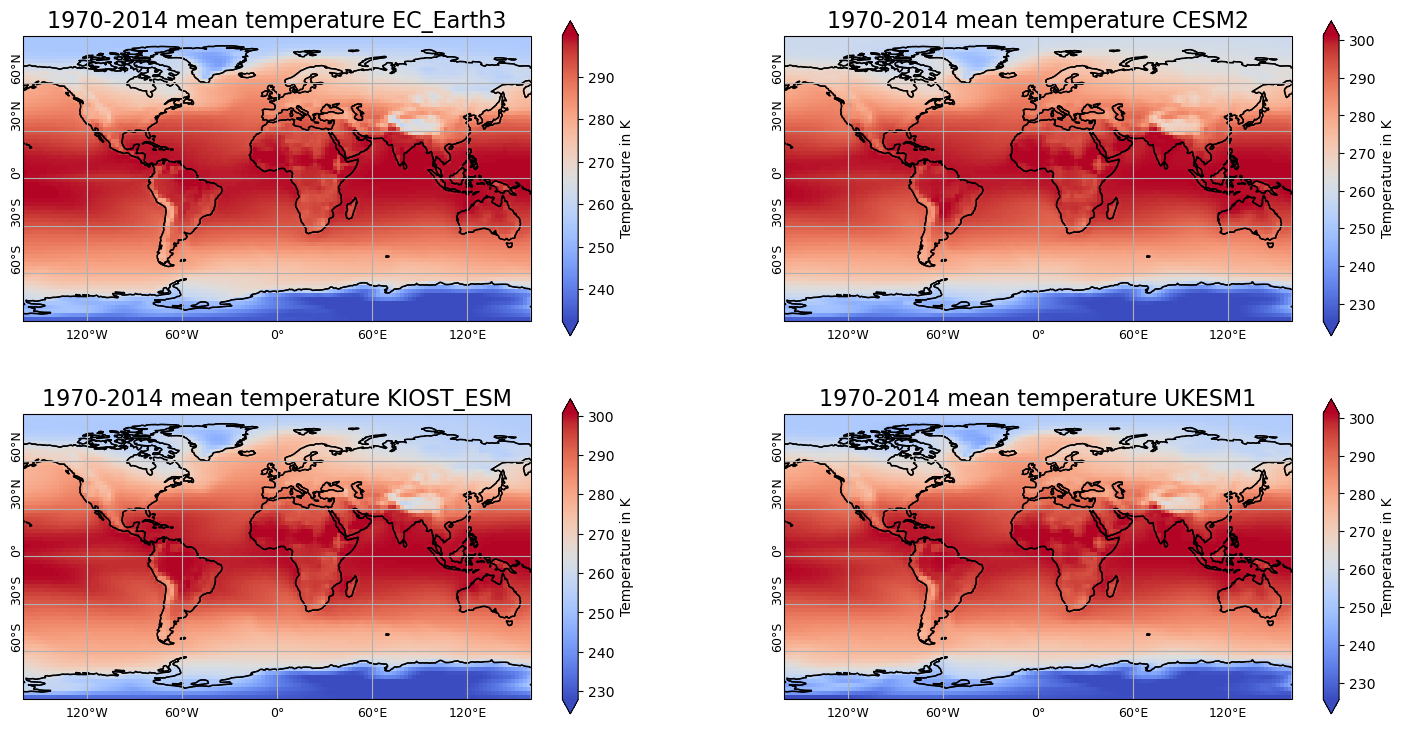

In [149]:
plot_4_models(models, models_names)

Next step is to plot the differences to ERA5 mean data. Again a function for the plotting is defined

In [150]:
def diffs_to_era5(models, era5_mean, models_names):
    """
    Function to plot four (and only four!) climate models and their differences to the era5 mean in a subplot. 
    Using  Plate-Carrée Porjections

    Keyword arguments:
    models -- dictionairy of the the model values and model names. Model value should be in global dimension lon/lat and contain
              only Temperature as variable in Kelvin
    models_name -- should be models_names = list(models.keys())
    era5_mean -- 
    
    Additional Info:
    ax --Prepare 4 axes for subplots. Setting  Plate-Carrée Porjections
    axes -- preparing list of axes for iterating
    index -- indices for iterating 
    
    Iterating for each subplot seperatly.
    i -- axes
    j -- index
    data -- save differnce of era5 to model data
    plot coastlines
    plot colormesh
    
    gl. ... --set x/y label in Degreees on bottom and left axes
    
    """
    fig = plt.figure(figsize = (18,9))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax1 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())

    axes = [ax0, ax1, ax2, ax3]
    index = [0,1,2,3]
    
    for i,j in zip(axes, index):
        data =  era5_mean - models[models_names[j]]
        i.coastlines()
        data.plot.pcolormesh(ax = i, cmap ='coolwarm', robust = True, cbar_kwargs={'label': "Temperature difference in K"})
        i.coastlines()
        i.set_extent([-160, 160, -90, 90])
        gl = i.gridlines(draw_labels = True)
        gl.xlabel_style = dict(fontsize = 9)
        gl.ylabel_style = dict(fontsize = 9, rotation = 90, va = 'bottom', ha = 'center')
        gl.top_labels = False
        gl.right_labels = False
        i.set_title("1970-2014 Diffs Temp: of {} to ERA5".format(models_names[j]), fontsize = 13)
        plt.savefig("diffs_to_era5.pdf")

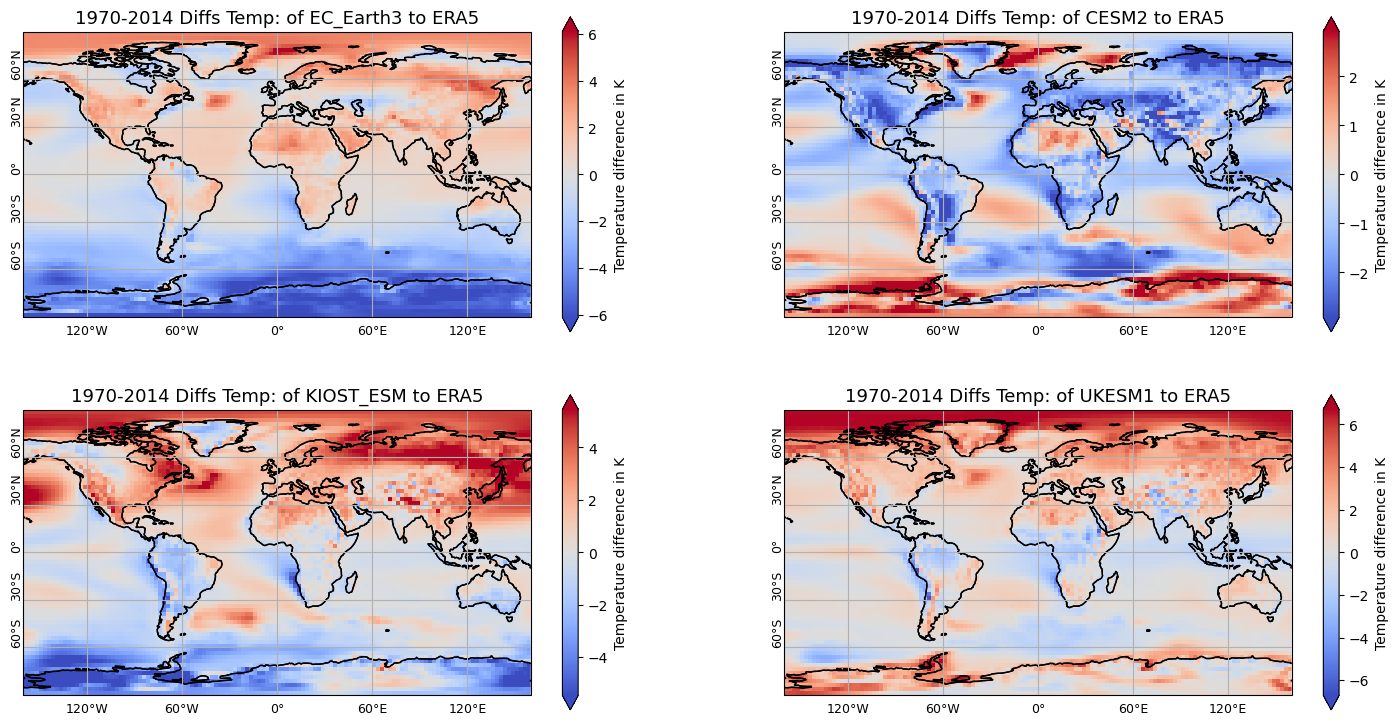

In [151]:
diffs_to_era5(models, ERA5_1970_2014_mean, models_names)

## Indicate the RMSE {-}

$$ RMSE = \sqrt{ \Sigma \frac{(x -\widehat{x})^2}{n}} $$

In [152]:
#define function for the calculation of of the RMSE
def RMSE(x,y):
    return calculate_global_mean_cos(np.sqrt(np.square(np.subtract(x,y))))

Next function is imported from Exercise 1

In [153]:
def calculate_global_mean_cos(ds):
    # NOTE: we use xarray here which is already a somewhat domain-specific 
    # Python package, in pure python this would be even more cumbersome

    # we need to know the name of the latitude and longtiude dimensions
    # so hardcode it here --> this will break for datasets with other names
    latn = 'lat'
    lonn = 'lon'

    # calculate weights to account for longitude convergence
    lats = ds[latn]
    weights_lat = np.cos(np.radians(lats))

    # calculate the area-weighted mean over latitude and longitude
    ds_mean = ds.weighted(weights_lat).mean(dim=[latn, lonn], keep_attrs=True)
    return ds_mean

In [154]:
#calculate mean of the differences
Earth3_diff = ERA5_1970_2014_mean - EC_Earth3_AerChem_1970_2014_mean
CESM2_diff = ERA5_1970_2014_mean - CESM2_1970_2014_mean
KIOST_diff = ERA5_1970_2014_mean - KIOST_ESM_1970_2014_mean
UKESM1_diff = ERA5_1970_2014_mean - UKESM1_1970_2014_mean

Earth3_diff_mean = calculate_global_mean_cos(Earth3_diff)
CESM2_diff_mean = calculate_global_mean_cos(CESM2_diff)
KIOST_diff_mean = calculate_global_mean_cos(KIOST_diff)
UKESM1_diff_mean = calculate_global_mean_cos(UKESM1_diff)

#RMSE of Difference!
RMSE_Earth3 = RMSE(Earth3_diff, Earth3_diff_mean)
RMSE_CESM2 = RMSE(CESM2_diff, CESM2_diff_mean)
RMSE_KIOST = RMSE(KIOST_diff, KIOST_diff_mean)
RMSE_UKESM1 = RMSE(UKESM1_diff, UKESM1_diff_mean)

In [155]:
print('RMSE of ERA5 and AWI_CM_1_1_MR is:', RMSE_Earth3.values.round(5))
print('RMSE of ERA5 and CESM2 is:', RMSE_CESM2.values.round(5))
print('RMSE of ERA5 and GFDL_CM4 is:', RMSE_KIOST.values.round(5))
print('RMSE of ERA5 and MPI_ESM_1_2_HAM is:', RMSE_UKESM1.values.round(5))

RMSE of ERA5 and AWI_CM_1_1_MR is: 1.38968
RMSE of ERA5 and CESM2 is: 0.86064
RMSE of ERA5 and GFDL_CM4 is: 1.51453
RMSE of ERA5 and MPI_ESM_1_2_HAM is: 1.11755


## Indicate the bias {-}

Statistical bias is a systematic tendency which causes differences between results and facts and therefore is the difference of the model value and a assumed "truth". The Bias of the models to ERA5 will be calculated in this step
$$ bias = x - \overline{x}$$

In [156]:
BIAS_Earth3_v2 = Earth3_diff - Earth3_diff_mean
BIAS_CESM2_v2 = CESM2_diff - CESM2_diff_mean
BIAS_KIOST_v2 = KIOST_diff - KIOST_diff_mean
BIAS_UKESM1_v2 = UKESM1_diff - UKESM1_diff_mean

models_bias = {"EC_Earth3_bias": BIAS_Earth3_v2,
    "CESM2_bias": BIAS_CESM2_v2,
    "KIOST_ESM_bias": BIAS_KIOST_v2,
    "UKESM1_bias": BIAS_UKESM1_v2}
models_names = list(models_bias.keys())

In [157]:
def plot_bias_fct(model_bias,model_name_bias):
    fig=plt.figure(figsize=(18,9))
    ax0 = plt.subplot2grid((2,2),(0,0),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax1 = plt.subplot2grid((2,2),(0,1),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax2 = plt.subplot2grid((2,2),(1,0),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax3 = plt.subplot2grid((2,2),(1,1),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    
    axes = [ax0,ax1,ax2,ax3]
    index = [0,1,2,3]
    
    for i,j in zip(axes,index):
        data = model_bias[model_name_bias[j]]
        #i.coastlines()
        data.plot.pcolormesh(ax = i, cmap='coolwarm', robust=True,label='T[K]',cbar_kwargs={'label':"Temperature [K]"})
        i.coastlines()
        i.set_extent([-160,160,-90,90])
        gl = i.gridlines(draw_labels = True)
        gl.xlabel_style = dict(fontsize=9)
        gl.ylabel_style = dict(fontsize=9,rotation=90,va='bottom',ha='center')
        gl.top_labels = False
        gl.right_labels = False
        i.set_title("Bias of the Difference of ERA5 and {} ".format(model_name_bias[j]),fontsize=12)
        plt.savefig("Bias.pdf")

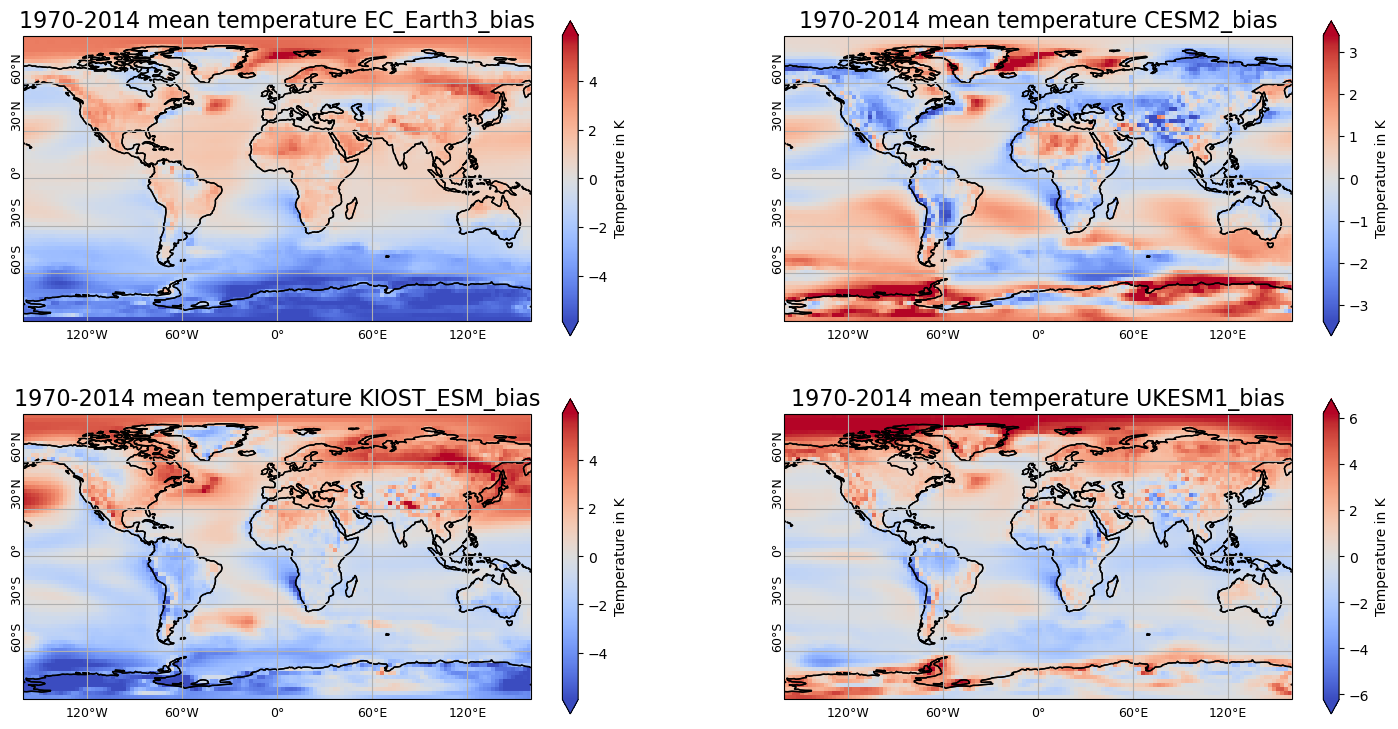

In [158]:
plot_4_models(models_bias, models_names)

## Docstring and plotting routine {-}

I used the functions above and added a EXTRA_ to the function name so they need to be imported to work because if not they would have already been loaded

In [159]:
import plots2_ex3 as plt_ex3

In [160]:
print(plt_ex3.EXTRA_plot_4_models.__doc__) # docstring


    Function to plot four (and only four!) climate models in a subplot. Using  Plate-Carrée Porjections

    Keyword arguments:
    models -- dictionairy of the the model values and model names. Model value should be in global dimension lon/lat and contain
              only Temperature as variable in Kelvin
    models_name -- should be models_names = list(models.keys())
    
    Additional Info:
    ax --Prepare 4 axes for subplots. Setting  Plate-Carrée Porjections
    axes -- preparing list of axes for iterating
    index -- indices for iterating 
    
    Iterating for each subplot seperatly.
    i -- axes
    j -- index
    data -- save model data
    plot coastlines
    plot colormesh
    
    gl. ... --set x/y label in Degreees on bottom and left axes
    


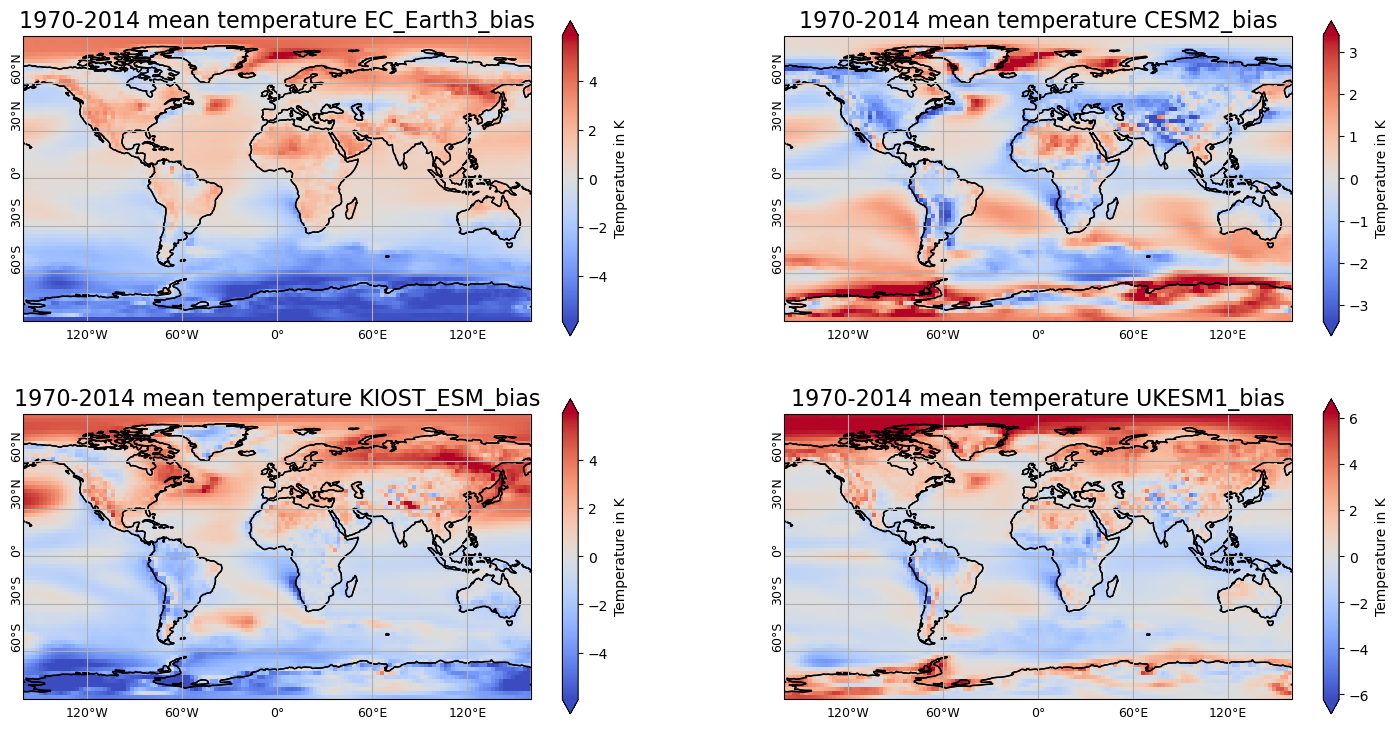

In [161]:
plt_ex3.EXTRA_plot_4_models(models_bias, models_names)

It works perfectly!

## Upload to Github {-}

``` bash

git clone git@github.com:livio-meteo/Modelling.git
cd Modelling_UE
git branch
git config --global user.name "livio-meteo" # could be any other name
git init
git status #check status
git add /users/students/livio-meteo/Modelling/Exercise_3/plots2_ex3.py
git commit -m "testing a commit and commit plots2_ex3.py"
git push -u origin Exercise_3
# Alternatively push to master/main is also possoble if the branch does not work
git log
```

# Task 3 {-}
Perform a principal component analysis on the annual mean temperature (1950-2022) from
ERA5 and/or CMIP6, treating each grid point as a separate ”station”. Focus on a specific
region of interest (e.g., Tropical Pacific, North Atlantic, Europe). Plot the resulting first four
loadings using the map plotting function from Example 2. Do the loadings reflect any familiar
oscillations?
Hint 1: To select a region you can crop the dataset using the following command (if it is an
Xarray dataset):
ds_crop = ds.sel(latitude=slice(lat0,lat1), longitude=slice(lon0,lon1))
Hint 2: You might need to reshape your dataset for the PCA to work (e.g. with np.reshape).

### Note: ERA5 is already yearly data{-}

In [162]:
ERA5 = xr.open_dataset("/users/students/a11808000/Modelling/Exercise_1/ERA5_EX3_2.nc") 
print('Time:', ERA5['time'].shape)
print('Longitude:', ERA5['lon'].shape)
print('Latitude:', ERA5['lat'].shape)

Time: (72,)
Longitude: (144,)
Latitude: (72,)


Next function is from Exercise 1 to correctly calculate annual mean also based on month length.

In [163]:
def calculate_annual_mean(ds):
    # we need the name of the time dimension
    timen = 'time'
    
    def _wmean(ds):
        days_in_month = ds[timen].dt.days_in_month
        weights_month = days_in_month / days_in_month.sum()
        ds_mean = ds.weighted(weights_month).mean(dim=timen, keep_attrs=True)
        return ds_mean
    
    ds_mean = ds.groupby('time.year').apply(_wmean)
    return ds_mean

In [164]:
ERA5_annual_mean = calculate_annual_mean(ERA5['t2m'])
print('Shape of annual time:', ERA5_annual_mean.shape[0])

Shape of annual time: 72


## PCA for Japan {-}

In [165]:
pca = PCA()

Japan is at lat [23.75, 51.25]  lon [118.75, 148.75] - In the dimensions of the dataset where lon -20W equals 340

In [166]:
lat0 = 23.75
lat1 = 51.25
lon0 = 118.75
lon1 = 148.75
ERA5_crop = ERA5_annual_mean.sel(lon=slice(lon0,lon1), lat=slice(lat0,lat1))

In [167]:
ERA5_crop.shape

(72, 12, 13)

In [168]:
pca.fit(np.reshape(ERA5_crop.values,(ERA5_crop['year'].shape[0], 156))) #156 = 12*13

PCA()

In [169]:
eigenvalues = pca.explained_variance_
loadings = pca.components_ #loadings sollte (72, 72*144)=(72,10 368) sein!
scores = pca.transform(np.reshape(ERA5_crop.values,(ERA5_crop['year'].shape[0], 156))) 

print('Shape of eigenvalues:', eigenvalues.shape)
print('Shape of loadings:', loadings.shape)
print('Shape of scores:', scores.shape)

Shape of eigenvalues: (72,)
Shape of loadings: (72, 156)
Shape of scores: (72, 72)


In [170]:
from cartopy.util import add_cyclic_point
x = np.arange(118.75, 151.25, 2.5) # 22
y = np.arange(23.75 , 53.75, 2.5) # 16

13
12
(72, 12, 13)


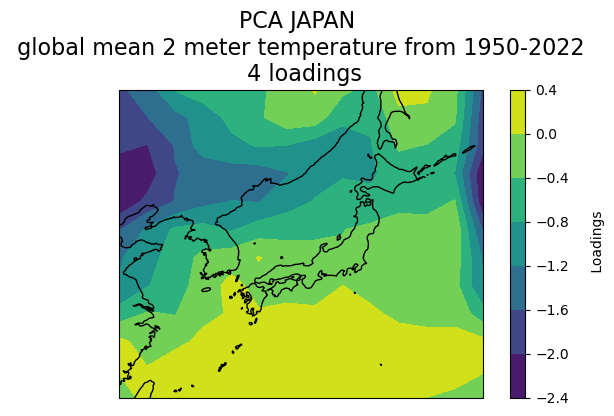

In [171]:
print(len(x))
print(len(y))

#PCA plot for the whole world
len_loadings = 4 #Plot the resulting first four loadings
pcana = np.zeros(np.shape(loadings))
for k in range(np.shape(pcana)[0]):
    for i in range(72):
        pcana[k] = pcana[k] + scores[k][i]*loadings[i]

pcana = np.reshape(pcana,(72,12,13))
print(pcana.shape)

fig = plt.figure(figsize = (7,4))
ax = plt.axes(projection=ccrs.PlateCarree())
pcana, x = add_cyclic_point(pcana, coord = x) # 72x22x16 22
plt.contourf(x, y,pcana[4])
plt.colorbar(label='\n Loadings')
ax.coastlines()
ax.set_title('PCA JAPAN \n global mean 2 meter temperature from 1950-2022 \n 4 loadings', fontsize=16)
plt.savefig("PCA_Japan.pdf")

### Plot the resulting first four loadings {-}

In [172]:
loadings= np.reshape(loadings,(72,12,13))
x = np.arange(118.75, 151.25, 2.5) # 22
y = np.arange(23.75 , 53.75, 2.5) # 16

In [173]:
def loadings_plot(x, y, loadings):
    fig = plt.figure(figsize = (15,7))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax1 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())

    axes = [ax0, ax1, ax2, ax3]
    index = [0,1,2,3]
    

    for i,j in zip(axes, index):
        loadings, x = add_cyclic_point(loadings, coord = x)
        cs = i.contourf(x, y, loadings[j])
        fig.colorbar(cs, ax = i, shrink=0.9, label=' Loading {}'.format(j + 1))
        i.coastlines()
        i.set_title('Loading {} (Japan) global mean 2m Temp'.format(j + 1), fontsize=16)
        i.set_extent([120, 150, 25, 50])
        plt.savefig("PCA_Japan_Loadings.pdf")

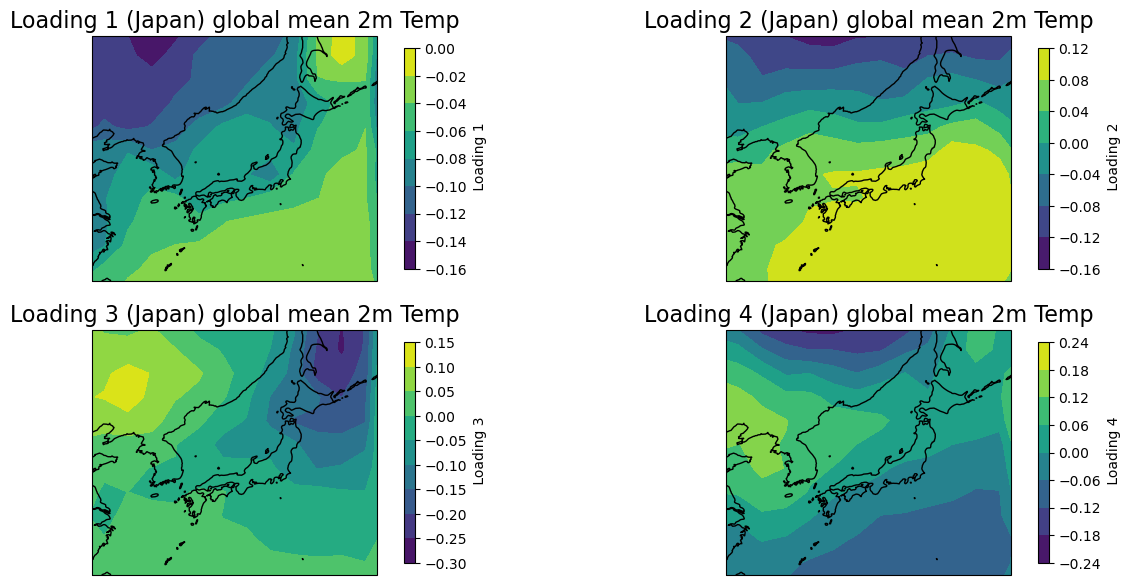

In [174]:
x = np.arange(118.75, 151.25, 2.5) # 22
y = np.arange(23.75 , 53.75, 2.5) # 16
loadings_plot(x, y, loadings)

#### Do the loadings reflect any familiar oscillations? {-}

In [175]:
loadings = pca.components_ 

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

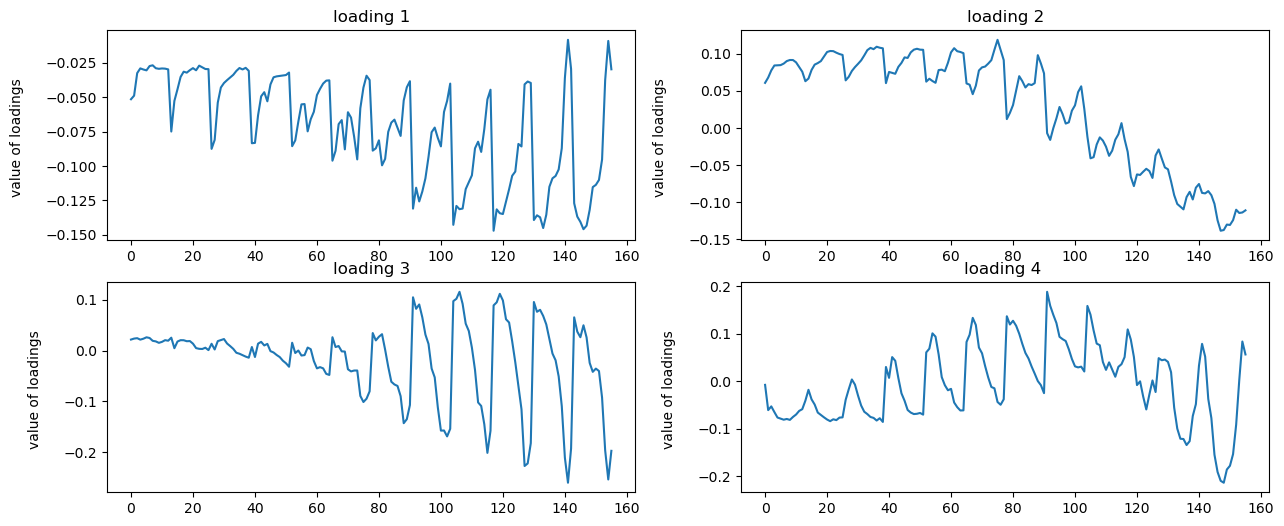

In [176]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(6)
fig.set_figwidth(15)

#loading 1
axs[0,0].plot(loadings[0])
axs[0,0].set_ylabel('value of loadings \n')
axs[0,0].set_title('loading 1')
#loading 2
axs[0,1].plot(loadings[1])
axs[0,1].set_ylabel('value of loadings \n')
axs[0,1].set_title('loading 2')
#loading 3
axs[1,0].plot(loadings[2])
axs[1,0].set_ylabel('value of loadings \n')
axs[1,0].set_title('loading 3')
#loading 4
axs[1,1].plot(loadings[3])
axs[1,1].set_ylabel('value of loadings \n')
axs[1,1].set_title('loading 4 ')
plt.savefig("oscillations.pdf")

plt.tight_layout

Higher Loadings correspond to a higher variability of the values of the loading. I think this can be explained by the stronger seasonability of higher lattitudes and thus lower variability of "stations" closer to the equator

# Task 4 {-}

Use the NumPy testing framework to test whether the dataset reconstructed from the principal
component loadings and scores computed in Example 3 is equal to the original dataset. Use the
function testing.assert_allclose() to allow for rounding errors up to a tolerance level.

ERA5_annual_mean[:, 45, 47] # corressponding to the lon lat  at 118.75 and 23.75 which corresponds to the lon/lat of ERA5_crop[:, 0, 0]

In [177]:
#for Japan 
np.testing.assert_allclose(ERA5_crop[:, 0, 0], pcana[:, 0, 0] + (ERA5_annual_mean[:, 45, 47]),rtol=1e-2) # only works till 1e-2

The same could be done for every station. But of course datasets of the same dimenson would be much more easily to handle due to the different lat/lon

# Task 5 {-}
Fill your online repository by adding the plots and scripts you got in the previous sub-tasks.
Before that check your code style and be sure that it passes flake8 without issues. Describe all
files in the repository in the README file. Then make the repository public or invite Daria as
a collaborator (daria.tatsii@univie.ac.at)

```bash 
pip install flake8
cd /users/students/a11808000/Modelling/Exercise_3/
flake8 plots_ex3.py
```

I corrected the .py file of plots_ex3.py which contains the plotting function of the previous tasks. It took me over 20min to correct and find every e.g. white space trailing at the end of a code line. I have learned the flake8 style but find it a little bit redundant to correct now the whole Exercise which would take hours for 90% commas and whitespaces. But for the next Exercises it will be taking into the mind!

When uploading to Github:
```bash
git add .
```

Adds all files of the current dictionary whichs makes commiting them much easier. The code to do it is already written in the Task when asked to upload the plotting function